# 015. word2vec 작성

- skipgram, window size 2 의 simplified word2vec model 작성

## 요약 (※ 순서를 지키지 않으면 한글 출력이 제대로 이루어지지 않을 수 있습니다.)

1. Google Colab의 노트북에서 위의 코드를 먼저 한번 실행 (폰트 설치 단계)  
2. 그 후 런타임 다시 시작 (설치된 폰트 적용 준비)  
3. 다시 위의 코드를 실행 (폰트 적용)  
4. 그 후 그래프 출력 코드 실행 (한글 정상 출력)  

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import numpy as np
import re

### Toy 말뭉치

In [2]:
corpus = ['king is a very strong man',
          'queen is a wise and pretty woman',
          'boy is a young man',
          'girl is a young and pretty woman',
          'prince is young and will be a strong and wise king',
          'princess is a young woman and will be a pretty and wise queen',
          'man is strong',
          'woman is pretty',
          'prince is a boy will be a king',
          'princess is a girl will be a queen',
         "a strong man will be a king",
        "the young boy is a prince",
        "a wise woman is a queen",
        "the girl is pretty and young",
        "a strong woman will be a queen",
        "the man is a wise and strong king",
        "the princess is a young and pretty girl",
        "a boy and a girl will be a man and a woman",
        "a pretty girl can be a princess",
        "the prince is a strong and wise boy"]

In [3]:
stop_words = ['is', 'a', 'will', 'be', 'and', 'the', 'can']
cleaned_corpus = []

for text in corpus:
    # 특수문자 제거 + 소문자 변환
    text = re.sub(r'[^a-zA-Z ]', '', text).lower()
    # 불용어 제거
    filtered = [word for word in text.split() if word not in stop_words]
    # 결과 저장
    cleaned_corpus.append(' '.join(filtered))

cleaned_corpus

['king very strong man',
 'queen wise pretty woman',
 'boy young man',
 'girl young pretty woman',
 'prince young strong wise king',
 'princess young woman pretty wise queen',
 'man strong',
 'woman pretty',
 'prince boy king',
 'princess girl queen',
 'strong man king',
 'young boy prince',
 'wise woman queen',
 'girl pretty young',
 'strong woman queen',
 'man wise strong king',
 'princess young pretty girl',
 'boy girl man woman',
 'pretty girl princess',
 'prince strong wise boy']

### vocaburary 모음 작성

In [4]:
words = []

for sentence in cleaned_corpus:
    for word in sentence.split(' '):
        words.append(word)

words = set(words)

### word-to-index, index-to-word 작성

- word 를 index 로 변환  

- sentence 를 word index 로 변환  

- window size 에 따라 train data 생성

In [5]:
word2index = dict((w, i) for i, w in enumerate(words))
index2word = dict((i, w) for i, w in enumerate(words))

In [6]:
word2index

{'strong': 0,
 'wise': 1,
 'young': 2,
 'boy': 3,
 'very': 4,
 'woman': 5,
 'pretty': 6,
 'king': 7,
 'girl': 8,
 'prince': 9,
 'princess': 10,
 'queen': 11,
 'man': 12}

### skip-gram 으로 training data 생성

In [7]:
sentences = []
for sentence in cleaned_corpus:
    sentences.append(sentence.split())
sentences

[['king', 'very', 'strong', 'man'],
 ['queen', 'wise', 'pretty', 'woman'],
 ['boy', 'young', 'man'],
 ['girl', 'young', 'pretty', 'woman'],
 ['prince', 'young', 'strong', 'wise', 'king'],
 ['princess', 'young', 'woman', 'pretty', 'wise', 'queen'],
 ['man', 'strong'],
 ['woman', 'pretty'],
 ['prince', 'boy', 'king'],
 ['princess', 'girl', 'queen'],
 ['strong', 'man', 'king'],
 ['young', 'boy', 'prince'],
 ['wise', 'woman', 'queen'],
 ['girl', 'pretty', 'young'],
 ['strong', 'woman', 'queen'],
 ['man', 'wise', 'strong', 'king'],
 ['princess', 'young', 'pretty', 'girl'],
 ['boy', 'girl', 'man', 'woman'],
 ['pretty', 'girl', 'princess'],
 ['prince', 'strong', 'wise', 'boy']]

In [8]:
WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] :
            if neighbor != word:
                data.append([word, neighbor])

In [9]:
data[:10]

[['king', 'very'],
 ['king', 'strong'],
 ['very', 'king'],
 ['very', 'strong'],
 ['very', 'man'],
 ['strong', 'king'],
 ['strong', 'very'],
 ['strong', 'man'],
 ['man', 'very'],
 ['man', 'strong']]

In [10]:
import pandas as pd

df = pd.DataFrame(data, columns = ['input', 'label'])
df.head()

,input,label
0,king,very
1,king,strong
2,very,king
3,very,strong
4,very,man


### One hot encoding

In [11]:
from tensorflow.keras.utils import to_categorical

len(words)

13

### One hot encoding 된 train, label data

In [12]:
X = [] # input word
Y = [] # target word

for x, y in zip(df['input'], df['label']):
    X.append(to_categorical(word2index[x], len(words)))
    Y.append(to_categorical(word2index[x], len(words)))

In [13]:
print(X[:3])
print(Y[:3])

[array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])]
[array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])]


In [14]:
# convert them to numpy arrays
X_train = np.array(X)
Y_train = np.array(Y)

**시각화를 위해 hidden layer 의 unit 을 2 로 제한**

In [15]:
model = Sequential()
model.add(Dense(2, input_dim=len(words)))
model.add(Dense(len(words)))

model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.fit(X_train, Y_train, epochs=50, batch_size=3)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0090 - loss: 5.5149
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0193 - loss: 7.8823
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0236 - loss: 8.2430
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0875 - loss: 8.0459
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0837 - loss: 6.4169
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1150 - loss: 7.0344
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1241 - loss: 8.0415
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1190 - loss: 7.6251
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1463 - loss: 7.6297
Epoch 10/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1342 - loss: 7.9017
Epoch 11/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1074 - loss: 8.3449
Epoch 12/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1117 - lo

### 첫번째 Hidden Layer 추출 및 weight + bias 를 vector 로 합산

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2)              │            28 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │            39 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203 (816.00 B)

 Trainable params: 67 (268.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 136 (548.00 B)

In [18]:
model.layers[0].get_weights()

[array([[-0.02187899, -0.02509646],
        [-0.01678084,  0.3975236 ],
        [-0.28912556,  0.57260984],
        [-0.45974803, -0.6073915 ],
        [-0.5588949 , -0.25463974],
        [-0.58776695, -0.3126629 ],
        [-0.26038736,  0.46449476],
        [-0.3335652 , -0.3938718 ],
        [ 0.18583748,  0.6023305 ],
        [-0.33765957, -0.15982276],
        [-0.14230667, -0.32649806],
        [-0.49872342, -0.26086265],
        [ 0.13305259,  0.34955233]], dtype=float32),
 array([ 0.02235133, -0.02055023], dtype=float32)]

In [19]:
model.layers[0].get_weights()[1]

array([ 0.02235133, -0.02055023], dtype=float32)

In [20]:
vectors= model.layers[0].get_weights()[0] + model.layers[0].get_weights()[1]
vectors[:5]

array([[ 4.7234260e-04, -4.5646690e-02],
       [ 5.5704918e-03,  3.7697339e-01],
       [-2.6677424e-01,  5.5205959e-01],
       [-4.3739671e-01, -6.2794173e-01],
       [-5.3654355e-01, -2.7518997e-01]], dtype=float32)

In [21]:
w2v = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v['word'] = list(words)
w2v['x1'] *= 10
w2v['x2'] *= 10
w2v

,x1,x2,word
0,0.004723,-0.456467,strong
1,0.055705,3.769734,wise
2,-2.667742,5.520596,young
3,-4.373967,-6.279417,boy
4,-5.365436,-2.751900,very
5,-5.654156,-3.332131,woman
6,-2.380360,4.439445,pretty
7,-3.112139,-4.144220,king
8,2.081888,5.817802,girl
9,-3.153082,-1.803730,prince


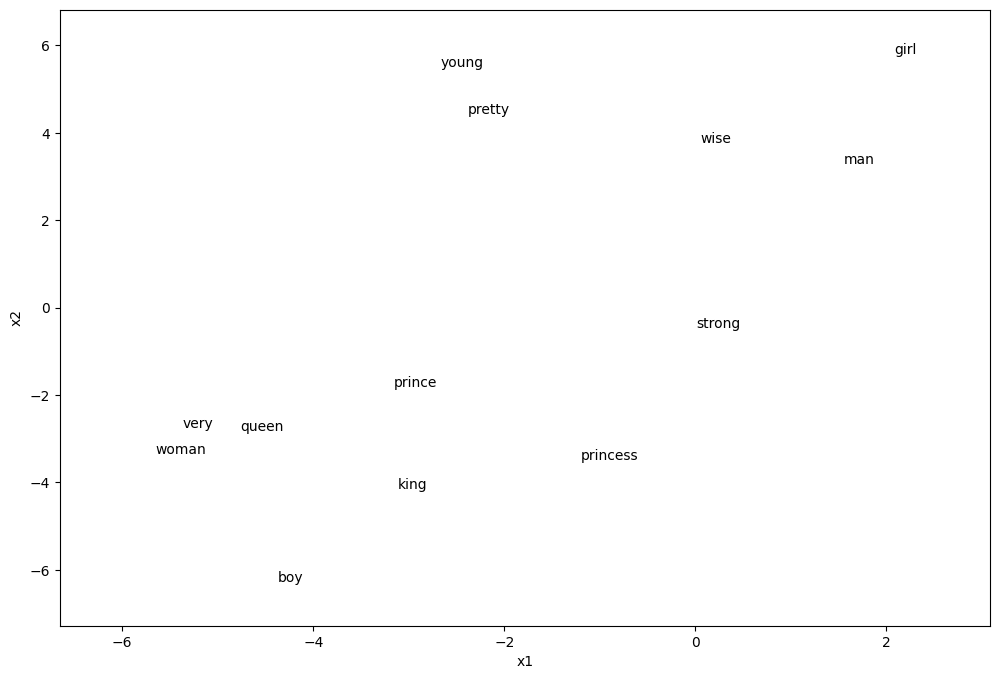

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))

for word, x1, x2 in zip(w2v['word'], w2v['x1'], w2v['x2']):
    ax.annotate(word, (x1, x2))

PADDING = 1.0
x_axis_min = np.min(vectors, axis=0)[0] - PADDING
y_axis_min = np.min(vectors, axis=0)[1] - PADDING
x_axis_max = np.max(vectors, axis=0)[0] + PADDING
y_axis_max = np.max(vectors, axis=0)[1] + PADDING

plt.xlim(x_axis_min, x_axis_max)
plt.ylim(y_axis_min, y_axis_max)
plt.xlabel('x1')
plt.ylabel('x2')

plt.show()